In [0]:
#MONTAGGIO DRIVE
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
!pip install segmentation_models

In [0]:
# unzip data e clean
!unzip -a "drive/My Drive/data.zip" -d "dataset1"
!rm -rf image-dataset/__MACOSX # rimuovo una cartella inutile creata con lo zip

Archive:  drive/My Drive/data.zip
  inflating: dataset1/TrayDataset/TrayDataset/XTest/1005a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/2002a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/3004a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/4003a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/5006a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/6004a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/7010a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTest/8006a.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a01.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a02.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a03.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a04.jpg  [binary]
  inflating: dataset1/TrayDataset/TrayDataset/XTrain/1001a05.jpg  [binary]
  inflating: da

In [0]:
# unzip data e clean
#!unzip -a "drive/My Drive/progetto/TrayDataset.zip" -d "dataset"
#!rm -rf image-dataset/__MACOSX # rimuovo una cartella inutile creata con lo zip

In [0]:
import pandas as pd
import numpy as np
from numpy.random import uniform
import segmentation_models as sm
import matplotlib.pyplot as plt
import scipy.io as sio
from imageio import imread
from os import listdir
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
import cv2
from keras import backend as K

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
background=[0,0,0]
tray=[1,1,1]
cutler=[2,2,2]
form=[3,3,3]
straw=[4,4,4]
meatball=[5,5,5]
beef=[6,6,6]
roastlamb=[7,7,7]
beeftomatocasserole=[8,8,8]
ham=[9,9,9]
bean=[10,10,10]
cucumber=[11,11,11]
leaf=[12,12,12]
tomato=[13,13,13]
boiledrice=[14,14,14]
beefmexicanmeatballs=[15,15,15]
spinachandpumpkinrisotto=[16,16,16]
bakedfish=[17,17,17]
gravy=[18,18,18]
zucchini=[19,19,19]
carrot=[20,20,20]
broccoli=[21,21,21]
pumpkin=[22,22,22]
celery=[23,23,23]
sandwich=[24,24,24]
sidesalad=[25,25,25]
tartaresauce=[26,26,26]
jacketpotato=[27,27,27]
creamedpotato=[28,28,28]
bread=[29,29,29]
margarine=[30,30,30]
soup=[31,31,31]
apple=[32,32,32]
cannedfruit=[33,33,33]
milk=[34,34,34]
vanillayogurt=[35,35,35]
jelly=[36,36,36]
custard=[37,37,37]
lemonsponge=[38,38,38]
juice=[39,39,39]
applejuice=[40,40,40]
orangejuice=[41,41,41]
water=[42,42,42]

# We dont want to classify unlabelled.it will only make our dataset more unbalanced than it already is
label_values = [background,tray,cutler,form,straw,meatball,beef,roastlamb,beeftomatocasserole,ham,bean,cucumber,leaf,tomato,boiledrice,
beefmexicanmeatballs,spinachandpumpkinrisotto,bakedfish,gravy,zucchini,carrot,broccoli,pumpkin,celery,sandwich,sidesalad,
tartaresauce,jacketpotato,creamedpotato,bread,margarine,soup,apple,cannedfruit,milk,vanillayogurt,jelly,custard,lemonsponge,
juice,applejuice,orangejuice,water]

In [0]:
path = './dataset1/'
# Definizione backbone, caricamento IO, e preprocess dell'input
BACKBONE = 'vgg19'
#preprocess_input = sm.get_preprocessing(BACKBONE) # attenzione, non utilizzata -> da problemi!

# load your data
x_train_val = []
for image in listdir(path+'TrayDataset/TrayDataset/XTrain/'):
    x_train_val.append((image,cv2.resize(imread(path+'TrayDataset/TrayDataset/XTrain/'+image),(416,256)),image[0]))
                                       
y_train_val =[]
for image in listdir(path+'TrayDataset/TrayDataset/yTrain/'):
    y_train_val.append((image,cv2.resize(imread(path+'TrayDataset/TrayDataset/yTrain/'+image),(416,256)),image[0]))


#print(x_train_val[0])   

In [0]:
# load your data for psp
x_train_val2 = []
for image in listdir(path+'TrayDataset/TrayDataset/XTrain/'):
    x_train_val2.append((image,cv2.resize(imread(path+'TrayDataset/TrayDataset/XTrain/'+image),(384,240),interpolation = cv2.INTER_AREA),image[0]))
                                       
y_train_val2 =[]
for image in listdir(path+'TrayDataset/TrayDataset/yTrain/'):
    y_train_val2.append((image,cv2.resize(imread(path+'TrayDataset/TrayDataset/yTrain/'+image),(384,240),interpolation = cv2.INTER_AREA),image[0]))


#print(x_train_val[0])   

In [0]:
# ordino i due vettori e ricontrollo
x_train_val.sort(key = lambda x: x[0])
y_train_val.sort(key = lambda x: x[0])
x_Train_Val = [i[1] for i in x_train_val]
y_Train_Val = [i[1] for i in y_train_val]


# mi prendo i label per fare una stratificazione
x_label = [i[2] for i in x_train_val]

del x_train_val
del y_train_val
# riduco in 0-1

x_Train_Val = np.array(x_Train_Val)
y_Train_Val = np.array(y_Train_Val)
# splitto in training e validation -> aggiunta stratificazione sul label elemento[0] del nome img
X_train, X_val, y_train, y_val = train_test_split(x_Train_Val, y_Train_Val, test_size=0.25, random_state=17, stratify = x_label)
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [0]:
# ordino i due vettori e ricontrollo per psp
x_train_val2.sort(key = lambda x: x[0])
y_train_val2.sort(key = lambda x: x[0])
x_Train_Val2 = [i[1] for i in x_train_val2]
y_Train_Val2 = [i[1] for i in y_train_val2]


# mi prendo i label per fare una stratificazione
x_label2 = [i[2] for i in x_train_val2]

del x_train_val2
del y_train_val2
# riduco in 0-1

x_Train_Val2 = np.array(x_Train_Val2)
y_Train_Val2 = np.array(y_Train_Val2)
# splitto in training e validation -> aggiunta stratificazione sul label elemento[0] del nome img
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_Train_Val2, y_Train_Val2, test_size=0.25, random_state=17, stratify = x_label2)
X_train2 = np.array(X_train2)
X_val2 = np.array(X_val2)
y_train2 = np.array(y_train2)
y_val2 = np.array(y_val2)

In [0]:
#normalizzazione per il test
x_Train_Val=np.array(x_Train_Val).astype('float32')/255
x_Train_Val2=np.array(x_Train_Val2).astype('float32')/255

In [0]:
#Normalizzazione X e one-hot y per train/val
X_train=np.array(X_train).astype('float32')/255
X_val=np.array(X_val).astype('float32')/255

X_train2=np.array(X_train2).astype('float32')/255
X_val2=np.array(X_val2).astype('float32')/255
#y_train_norm = np.array([one_hot_it(y_train[i],label_values) for i in range(len(y_train))])
#del y_train
#y_val_norm = np.array([one_hot_it(y_val[i],label_values) for i in range(len(y_val))])
#del y_val

In [0]:
#del y_train_norm
#del y_val_norm
#del y_train

In [0]:
import keras.backend as K

def iou_coef(y_true, y_pred):
  smooth=1
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3]) #moltiplicazione element 
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

# IoU = (|X &amp; Y|)/ (|X or Y|)
def iou_coef_loss(y_true, y_pred):
  return 1-iou_coef(y_true, y_pred)


meanIOU = tf.keras.metrics.MeanIoU(num_classes=43)

In [0]:
from keras.models import load_model
model1 = load_model('drive/My Drive/ago',compile =False)
model2 = load_model('drive/My Drive/gimmi',compile =False)
model3 = load_model('drive/My Drive/zenzo2.h5',compile =False)

lr = 0.0019366687517469762
adam = Adam(learning_rate=lr)
model1.compile(adam, loss = sm.losses.JaccardLoss(), metrics = ['accuracy', sm.metrics.IOUScore(), meanIOU, iou_coef])

#lr2 = 0.002771462109359584
adam2 = Adam()
model2.compile(
    adam2,
    loss=sm.losses.JaccardLoss(), 
    #loss = 'categorical_crossentropy',
    metrics =['accuracy', sm.metrics.IOUScore(), meanIOU, iou_coef]
    )


model3.compile(adam2,loss=sm.losses.JaccardLoss(),metrics =[iou_coef])


In [0]:
#PREDICT
pred1 = model1.predict(X_val)
y_class1 = pred1.argmax(axis=-1)
del pred1


pred2 = model2.predict(X_val2)
#Make prediction in correct dimension
pred_r = []
for i in range (0,pred2.shape[0]):
  pred_r.append(cv2.resize(pred2[i],(416,256),interpolation = cv2.INTER_AREA))  
pred_r = np.array(pred_r)
y_class2 = pred_r.argmax(axis=-1)
#y_class2 = pred2.argmax(axis=-1)
del pred2
del pred_r


pred3 = model3.predict(X_val)
y_class3 = pred3.argmax(axis=-1)
del pred3

In [0]:
print(y_class3.shape)

(311, 256, 416)


In [0]:
#VOTING
y_class1 = y_class1.flatten()
y_class2 = y_class2.flatten()
y_class3 = y_class3.flatten()
#size per il test->cambiare per il val
x = 256*416*311
y_fin = np.zeros(x).astype('int')

for i, x in enumerate(y_class1):
  elem = np.zeros(43).astype('int')
  elem[x] += 1
  elem[y_class2[i]] += 1
  elem[y_class3[i]] += 1
  #if(i==0):
  #  print(elem)
  maximo = elem.argmax(axis=0)
  y_fin[i] = maximo

#print(maximo)

In [0]:
#y_pred
#cambiare dim 0 per il validation
y_fin = y_fin.reshape(311, 256, 416)

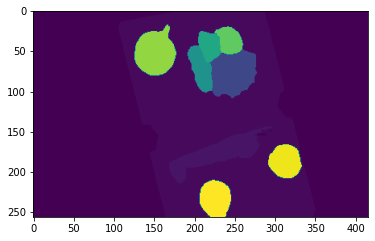

In [0]:
import matplotlib.pyplot as plt

plt.imshow(y_fin[0])

In [0]:
#VALUTAZIONE ACCURACY
def categorical_accuracy(y_true, y_pred):
  return K.cast(K.equal(y_true, y_pred), K.floatx())

In [0]:
#print(y_val.shape)
#y_Train_Val=y_Train_Val[:,:,:,0]
y_val=y_val[:,:,:,0]
#print(y_val.shape)
y_fin = y_fin.flatten()
#y_Train_Val = y_Train_Val.flatten()
y_val=y_val.flatten()

accuracy = categorical_accuracy(y_val, y_fin)

print(K.sum(accuracy)/33120256)

tf.Tensor(0.9881291, shape=(), dtype=float32)


**ELABORAZIONI PER VALUTARE L'IOU**

In [0]:
def one_hot_it(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    #print('Start One-Hot Vectorizing...')
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    #print('Done..')
    return semantic_map

In [0]:
#y_Train_Val= y_Train_Val.reshape(8, 256, 416)
#print(y_Train_Val.shape)
y_val =y_val.reshape(311, 256, 416)
y_fin = y_fin.reshape(311, 256, 416)
print(y_fin.shape)



(311, 256, 416)


In [0]:
imlist=[]
for i in range(0,y_val.shape[0]):
  temp=np.array([[y_val[i,:,:]],[y_val[i,:,:]],[y_val[i,:,:]]])
  temp=temp.squeeze()
  temp=temp.reshape((256,416,3))
  imlist.append(temp)
  print(temp.shape) 

imlist2=[]
for i in range(0,y_fin.shape[0]):
  temp=np.array([[y_fin[i,:,:]],[y_fin[i,:,:]],[y_fin[i,:,:]]])
  temp=temp.squeeze()
  temp=temp.reshape((256,416,3))
  imlist2.append(temp)
  print(temp.shape) 


(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 416, 3)
(256, 

In [0]:
y_val=np.array(imlist)
y_fin=np.array(imlist2)

print(y_val.shape)
print(y_fin.shape)

(311, 256, 416, 3)
(311, 256, 416, 3)


In [0]:
#y_Train_Val_norm = np.array([one_hot_it(y_Train_Val[i],label_values) for i in range(len(y_Train_Val))])
y_val_norm = np.array([one_hot_it(y_val[i],label_values) for i in range(len(y_val))])
y_fin_norm = np.array([one_hot_it(y_fin[i],label_values) for i in range(len(y_fin))])

#print(y_Train_Val_norm.shape)

In [0]:
###### definizione loss e iou
def iou_coef(y_true, y_pred, smooth=1):
 intersection = np.sum(np.abs(y_true * y_pred), axis=(1,2,3))
 union = np.sum(y_true,(1,2,3))+np.sum(y_pred,(1,2,3))-intersection
 iou = np.mean((intersection + smooth) / (union + smooth), axis=0)
 return iou


In [0]:
iou_coef(y_val_norm,y_fin_norm)

0.977057530100651